In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


import pickle


import sys
sys.path.append("..")

Page to download the data --> [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

# Short prediction

In [2]:
# Trip_type
# 1= Street-hail
# 2= Dispatch

In [39]:
def read_dataframe(filename):

    df = pd.read_parquet(filename)

    df.loc[:, 'lpep_dropoff_datetime'] = pd.to_datetime(df.lpep_dropoff_datetime)
    df.loc[:, 'lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime)

    # Duration in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[((df.duration >= 1) & (df.duration <= 60))]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)

    return df

In [57]:
print(df_train.dtypes.value_counts())
print("\n")
print("The dataset shape is", df_train.shape)

float64           14
object             4
datetime64[us]     2
int64              1
Name: count, dtype: int64


The dataset shape is (73908, 21)


In [44]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet").sample(frac=0.8, random_state=42)

In [45]:
print('dataset to train', len(df_train))
print('dataset to val', len(df_val))

dataset to train 73908
dataset to val 59126


In [47]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [48]:
# Almost all the durarion is focused on 98%
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [67]:
# We can attempt some feature engineering to improve the MAE

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' +df_val['DOLocationID']

In [68]:
categorical = ['PU_DO']
#categorical = ['PULocationID', 'DOLocationID'] initial approach
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')


X_train = dv.fit_transform(train_dicts) # Matrix used to train the model

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [69]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

## Linear Regression

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('MSE', mean_squared_error(y_train, y_pred))
print('MAE', mean_absolute_error(y_train, y_pred))

MSE 32.485031137461576
MAE 4.130066979934783


/tmp/ipykernel_16600/4107668193.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/tmp/ipykernel_16600/4107668193.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




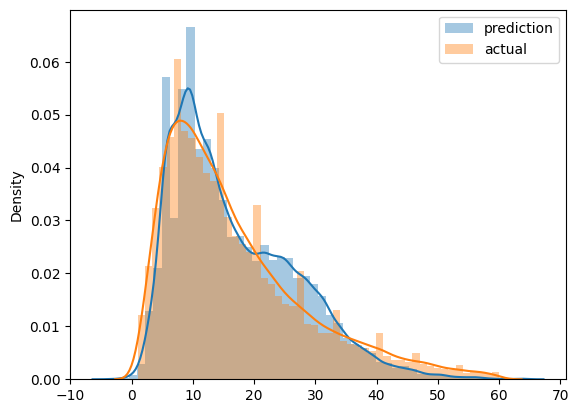

In [71]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

## Lasso

In [72]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('MSE', mean_squared_error(y_train, y_pred))
print('MAE', mean_absolute_error(y_train, y_pred))

MSE 111.31260798576498
MAE 7.946548487205934


## Ridge

In [73]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('MSE', mean_squared_error(y_train, y_pred))
print('MAE', mean_absolute_error(y_train, y_pred))

MSE 31.875181052606937
MAE 4.023436257194894


## Save the model

In [75]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)